In [ ]:
!pip install tensorflow keras numpy pandas opencv-python kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"poornasaikrishna1","key":"3e2852f31712edd74fe141c2191b6238"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [ ]:
!unzip /content/brain-tumor-mri-dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0726.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0727.jpg  
  inflating: dataset/Training/glioma/Tr-gl_0728.jpg  
  inflating: dataset/Training/g

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Paths to the dataset
TRAIN_DIR = "/content/dataset/Training"  # Replace with the path to the training set
TEST_DIR = "/content/dataset/Testing"   # Replace with the path to the testing set

# Set image dimensions and other params
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load training dataset
train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",  # One-hot encode the labels
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# Load testing dataset
test_dataset = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Split the training dataset into train and validation sets
val_dataset = train_dataset.take(int(0.2 * len(train_dataset)))  # 20% validation
train_dataset = train_dataset.skip(int(0.2 * len(train_dataset)))  # Remaining 80% for training

# Normalize the pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Cache the datasets for faster loading
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Model

def build_combined_model(input_shape=(224, 224, 3), num_classes=4):
    # EfficientNetB0 Branch
    efficient_net = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    efficient_net.trainable = False  # Freeze EfficientNet layers
    x1 = GlobalAveragePooling2D()(efficient_net.output)

    # DenseNet121 Branch
    densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
    densenet.trainable = False  # Freeze DenseNet layers
    x2 = GlobalAveragePooling2D()(densenet.output)

    # AlexNet-like Branch
    alexnet_input = Input(shape=input_shape)
    x3 = Conv2D(96, (11, 11), strides=4, activation="relu")(alexnet_input)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Conv2D(256, (5, 5), padding="same", activation="relu")(x3)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Conv2D(384, (3, 3), padding="same", activation="relu")(x3)
    x3 = Conv2D(384, (3, 3), padding="same", activation="relu")(x3)
    x3 = Conv2D(256, (3, 3), padding="same", activation="relu")(x3)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Flatten()(x3)

    # Combine the outputs of the three branches
    combined = concatenate([x1, x2, x3])
    fc = Dense(512, activation="relu")(combined)
    fc = Dense(128, activation="relu")(fc)
    output = Dense(num_classes, activation="softmax")(fc)

    # Create final model
    model = Model(inputs=[efficient_net.input, densenet.input, alexnet_input], outputs=output)
    return model

In [ ]:
# Build the model
model = build_combined_model()

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,357,415 (73.84 MB)

 Trainable params: 8,270,340 (31.55 MB)

 Non-trainable params: 11,087,075 (42.29 MB)

In [ ]:
# Multi-input datasets for training
train_inputs = [tf.data.Dataset.map(lambda x, y: (x, y)) for _ in range(3)]  # 3 branches

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    batch_size=BATCH_SIZE,
)

TypeError: DatasetV2.map() missing 1 required positional argument: 'map_func'

Loading Dataset...
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Training dataset size: 144 batches
Validation dataset size: 35 batches
Testing dataset size: 41 batches
Building Model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,357,415 (73.84 MB)

 Trainable params: 8,270,340 (31.55 MB)

 Non-trainable params: 11,087,075 (42.29 MB)

Training Model...
Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 132s 472ms/step - accuracy: 0.6302 - loss: 0.9621 - val_accuracy: 0.8330 - val_loss: 0.4078
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 58s 157ms/step - accuracy: 0.8670 - loss: 0.3655 - val_accuracy: 0.8902 - val_loss: 0.2897
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.8921 - loss: 0.2806 - val_accuracy: 0.9205 - val_loss: 0.2118
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.9222 - loss: 0.2227 - val_accuracy: 0.9295 - val_loss: 0.2034
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.9366 - loss: 0.1943 - val_accuracy: 0.9134 - val_loss: 0.2198
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - accuracy: 0.9236 - loss: 0.1984 - val_accuracy: 0.9107 - val_loss: 0.2434
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.9393 - loss: 0.1656 - val_accuracy: 0.9393 - val_loss: 0.1666
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accurac

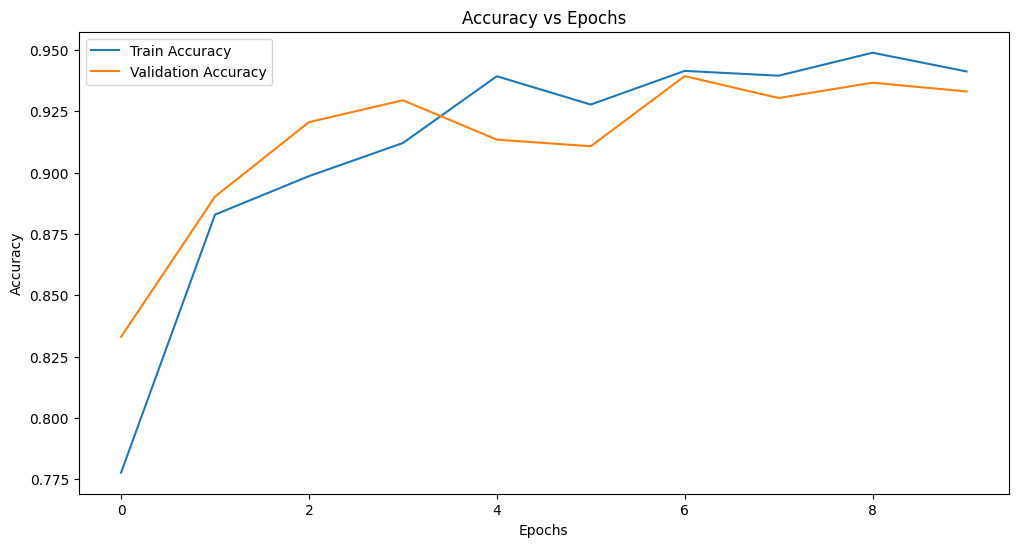

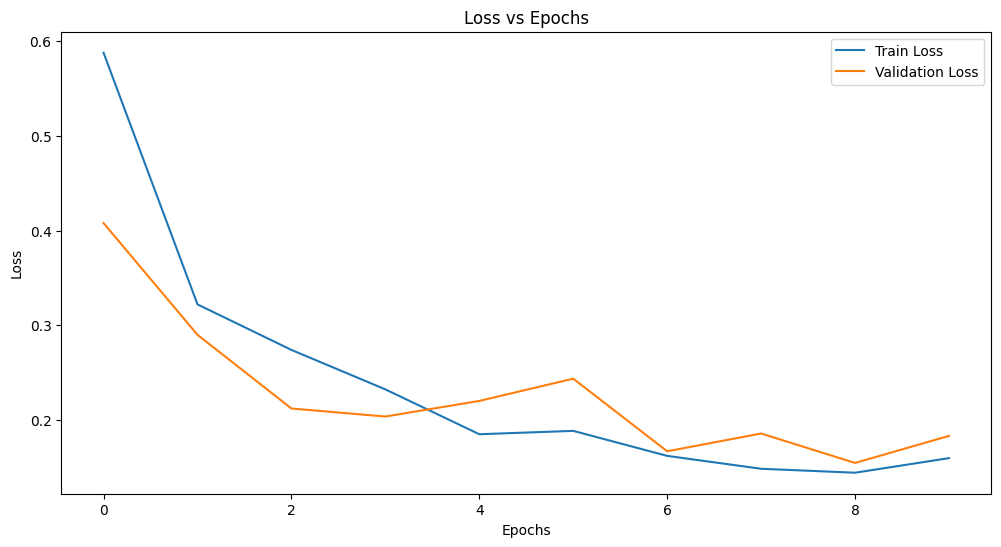

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Paths to Dataset
TRAIN_DIR = "/content/dataset/Training"  # Replace with path to Training folder
TEST_DIR = "/content/dataset/Testing"    # Replace with path to Testing folder

# Image settings
IMG_SIZE = (224, 224)  # Resize all images to this size
BATCH_SIZE = 32

# Step 1: Load Dataset
print("Loading Dataset...")

train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',  # One-hot encoding labels
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Split train dataset into train (80%) and validation (20%)
val_dataset = train_dataset.take(int(0.2 * len(train_dataset)))  # Take 20% for validation
train_dataset = train_dataset.skip(int(0.2 * len(train_dataset)))  # Remaining for training

print(f"Training dataset size: {len(train_dataset)} batches")
print(f"Validation dataset size: {len(val_dataset)} batches")
print(f"Testing dataset size: {len(test_dataset)} batches")

# Step 2: Normalize and Cache Datasets
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)  # Normalize images to [0, 1]

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Step 3: Prepare Multi-Input Datasets
def prepare_multi_input_dataset(dataset):
    """
    Converts the dataset for use in the multi-input model.
    Each image is duplicated for separate branches (e.g., EfficientNet, DenseNet, AlexNet).
    """
    return dataset.map(lambda x, y: ((x, x, x), y))  # Three inputs, one for each branch

train_dataset_multi = prepare_multi_input_dataset(train_dataset)
val_dataset_multi = prepare_multi_input_dataset(val_dataset)
test_dataset_multi = prepare_multi_input_dataset(test_dataset)

# Step 4: Define the Multi-Branch Model
def build_combined_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Build the multi-branch model combining EfficientNet, DenseNet, and AlexNet-like architecture.
    """
    # EfficientNetB0 Branch
    efficient_net = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    efficient_net.trainable = False  # Freeze EfficientNet layers
    x1 = GlobalAveragePooling2D()(efficient_net.output)

    # DenseNet121 Branch
    densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
    densenet.trainable = False  # Freeze DenseNet layers
    x2 = GlobalAveragePooling2D()(densenet.output)

    # AlexNet-like Branch
    alexnet_input = Input(shape=input_shape)
    x3 = Conv2D(96, (11, 11), strides=4, activation="relu")(alexnet_input)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Conv2D(256, (5, 5), padding="same", activation="relu")(x3)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Conv2D(384, (3, 3), padding="same", activation="relu")(x3)
    x3 = Conv2D(384, (3, 3), padding="same", activation="relu")(x3)
    x3 = Conv2D(256, (3, 3), padding="same", activation="relu")(x3)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Flatten()(x3)

    # Combine the outputs of the three branches
    combined = concatenate([x1, x2, x3])
    fc = Dense(512, activation="relu")(combined)
    fc = Dense(128, activation="relu")(fc)
    output = Dense(num_classes, activation="softmax")(fc)  # Output layer with 4 classes

    # Create final model
    model = Model(inputs=[efficient_net.input, densenet.input, alexnet_input], outputs=output)
    return model

# Step 5: Build the Model
print("Building Model...")
model = build_combined_model()
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# Step 6: Train the Model
print("Training Model...")
history = model.fit(
    train_dataset_multi,
    validation_data=val_dataset_multi,
    epochs=10,
    batch_size=BATCH_SIZE
)

# Step 7: Evaluate the Model
print("Evaluating Model...")
test_loss, test_acc = model.evaluate(test_dataset_multi)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Step 8: Visualize Training/Validation Metrics
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

Loading Dataset...
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Training dataset size: 144 batches
Validation dataset size: 35 batches
Testing dataset size: 41 batches
Building Model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,357,415 (73.84 MB)

 Trainable params: 8,270,340 (31.55 MB)

 Non-trainable params: 11,087,075 (42.29 MB)

Training Model...
Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 134s 481ms/step - accuracy: 0.6702 - loss: 0.8868 - val_accuracy: 0.8536 - val_loss: 0.3735
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 58s 171ms/step - accuracy: 0.8719 - loss: 0.3375 - val_accuracy: 0.8911 - val_loss: 0.2967
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - accuracy: 0.9001 - loss: 0.2791 - val_accuracy: 0.9187 - val_loss: 0.2250
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.9117 - loss: 0.2278 - val_accuracy: 0.8991 - val_loss: 0.2520
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 0.9194 - loss: 0.2205 - val_accuracy: 0.9161 - val_loss: 0.2126
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - accuracy: 0.9383 - loss: 0.1709 - val_accuracy: 0.9080 - val_loss: 0.2647
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.9393 - loss: 0.1803 - val_accuracy: 0.9277 - val_loss: 0.1854
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step - accurac

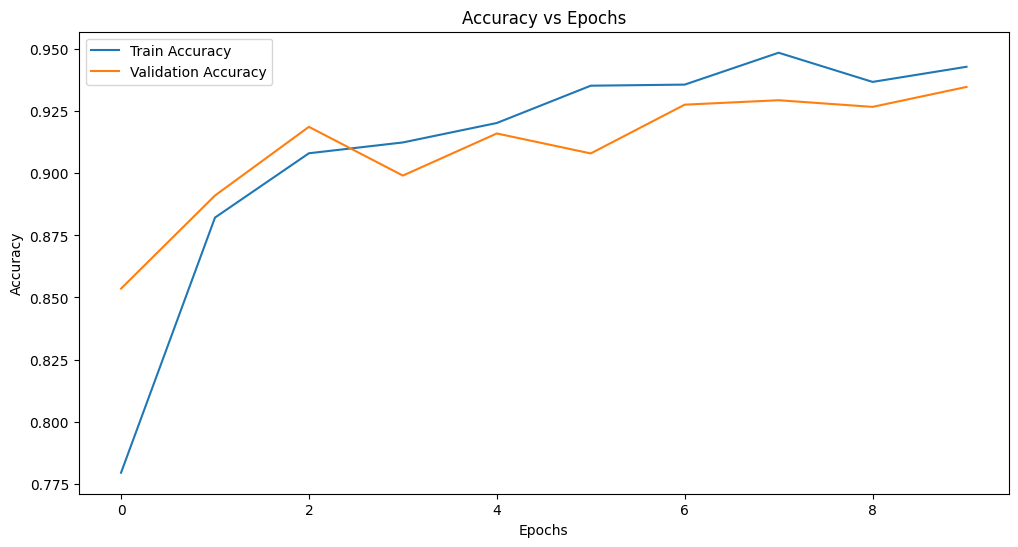

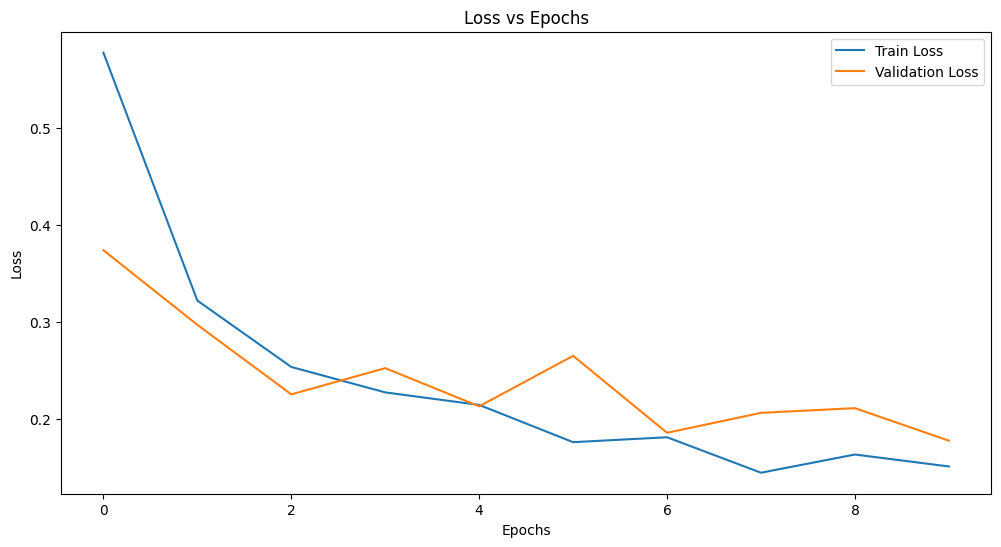

Generating Confusion Matrix...
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 539ms/step


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Paths to Dataset
TRAIN_DIR = "/content/dataset/Training"  # Replace with path to Training folder
TEST_DIR = "/content/dataset/Testing"    # Replace with path to Testing folder

# Image settings
IMG_SIZE = (224, 224)  # Resize all images to this size
BATCH_SIZE = 32

# Step 1: Load Dataset
print("Loading Dataset...")

train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',  # One-hot encoding labels
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Split train dataset into train (80%) and validation (20%)
val_dataset = train_dataset.take(int(0.2 * len(train_dataset)))  # Take 20% for validation
train_dataset = train_dataset.skip(int(0.2 * len(train_dataset)))  # Remaining for training

print(f"Training dataset size: {len(train_dataset)} batches")
print(f"Validation dataset size: {len(val_dataset)} batches")
print(f"Testing dataset size: {len(test_dataset)} batches")

# Step 2: Normalize and Cache Datasets
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)  # Normalize images to [0, 1]

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Step 3: Prepare Multi-Input Datasets
def prepare_multi_input_dataset(dataset):
    """
    Converts the dataset for use in the multi-input model.
    Each image is duplicated for separate branches (e.g., EfficientNet, DenseNet, AlexNet).
    """
    return dataset.map(lambda x, y: ((x, x, x), y))  # Three inputs, one for each branch

train_dataset_multi = prepare_multi_input_dataset(train_dataset)
val_dataset_multi = prepare_multi_input_dataset(val_dataset)
test_dataset_multi = prepare_multi_input_dataset(test_dataset)

# Step 4: Define the Multi-Branch Model
def build_combined_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Build the multi-branch model combining EfficientNet, DenseNet, and AlexNet-like architecture.
    """
    # EfficientNetB0 Branch
    efficient_net = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    efficient_net.trainable = False  # Freeze EfficientNet layers
    x1 = GlobalAveragePooling2D()(efficient_net.output)

    # DenseNet121 Branch
    densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
    densenet.trainable = False  # Freeze DenseNet layers
    x2 = GlobalAveragePooling2D()(densenet.output)

    # AlexNet-like Branch
    alexnet_input = Input(shape=input_shape)
    x3 = Conv2D(96, (11, 11), strides=4, activation="relu")(alexnet_input)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Conv2D(256, (5, 5), padding="same", activation="relu")(x3)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Conv2D(384, (3, 3), padding="same", activation="relu")(x3)
    x3 = Conv2D(384, (3, 3), padding="same", activation="relu")(x3)
    x3 = Conv2D(256, (3, 3), padding="same", activation="relu")(x3)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Flatten()(x3)

    # Combine the outputs of the three branches
    combined = concatenate([x1, x2, x3])
    fc = Dense(512, activation="relu")(combined)
    fc = Dense(128, activation="relu")(fc)
    output = Dense(num_classes, activation="softmax")(fc)  # Output layer with 4 classes

    # Create final model
    model = Model(inputs=[efficient_net.input, densenet.input, alexnet_input], outputs=output)
    return model

# Step 5: Build the Model
print("Building Model...")
model = build_combined_model()
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# Step 6: Train the Model
print("Training Model...")
history = model.fit(
    train_dataset_multi,
    validation_data=val_dataset_multi,
    epochs=10,
    batch_size=BATCH_SIZE
)

# Step 7: Evaluate the Model
print("Evaluating Model...")
test_loss, test_acc = model.evaluate(test_dataset_multi)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Step 8: Visualize Training/Validation Metrics
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# Step 9: Generate a Confusion Matrix
print("Generating Confusion Matrix...")

# Get true labels and predictions for the test dataset
y_true = np.concatenate([y.numpy() for _, y in test_dataset])
y_pred_probs = model.predict(test_dataset_multi)  # Model predictions (as probabilities)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert predicted probabilities to class indices
y_true = np.argmax(y_true, axis=1)  # Convert one-hot true labels to class indices

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = test_dataset.class_names  # Get class names from dataset

# Display the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, colorbar=True)  # Use a blue color map
plt.title("Confusion Matrix")
plt.show()

Loading Dataset...
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Training dataset size: 144 batches
Validation dataset size: 35 batches
Testing dataset size: 41 batches
Building Model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,357,415 (73.84 MB)

 Trainable params: 8,270,340 (31.55 MB)

 Non-trainable params: 11,087,075 (42.29 MB)

Training Model...
Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 143s 522ms/step - accuracy: 0.6345 - loss: 0.9377 - val_accuracy: 0.8589 - val_loss: 0.3780
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.8724 - loss: 0.3473 - val_accuracy: 0.9161 - val_loss: 0.2595
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.8819 - loss: 0.3065 - val_accuracy: 0.8893 - val_loss: 0.3007
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.9141 - loss: 0.2313 - val_accuracy: 0.9000 - val_loss: 0.2780
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.9161 - loss: 0.2270 - val_accuracy: 0.9152 - val_loss: 0.2282
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.9338 - loss: 0.1874 - val_accuracy: 0.8830 - val_loss: 0.3070
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.9261 - loss: 0.2003 - val_accuracy: 0.9223 - val_loss: 0.2081
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accurac

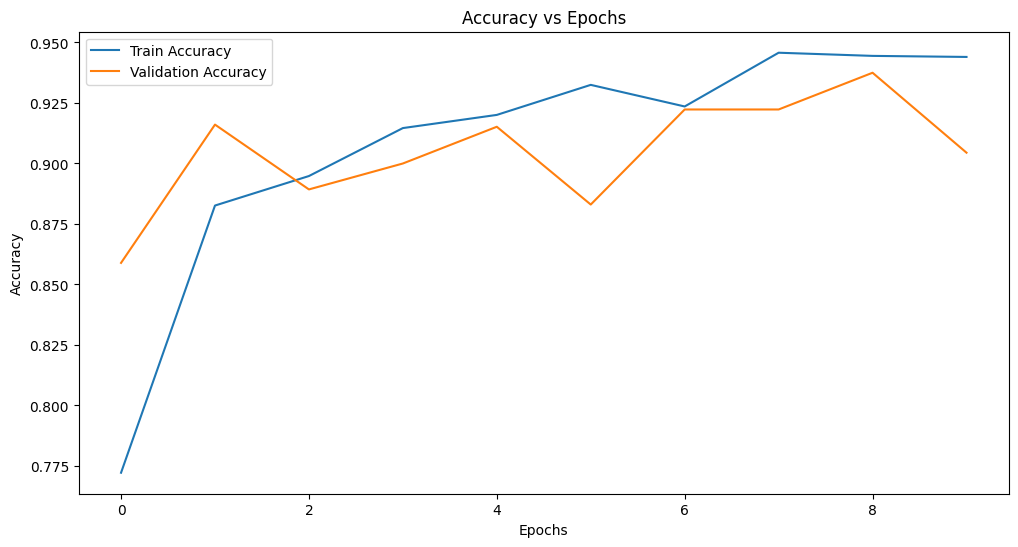

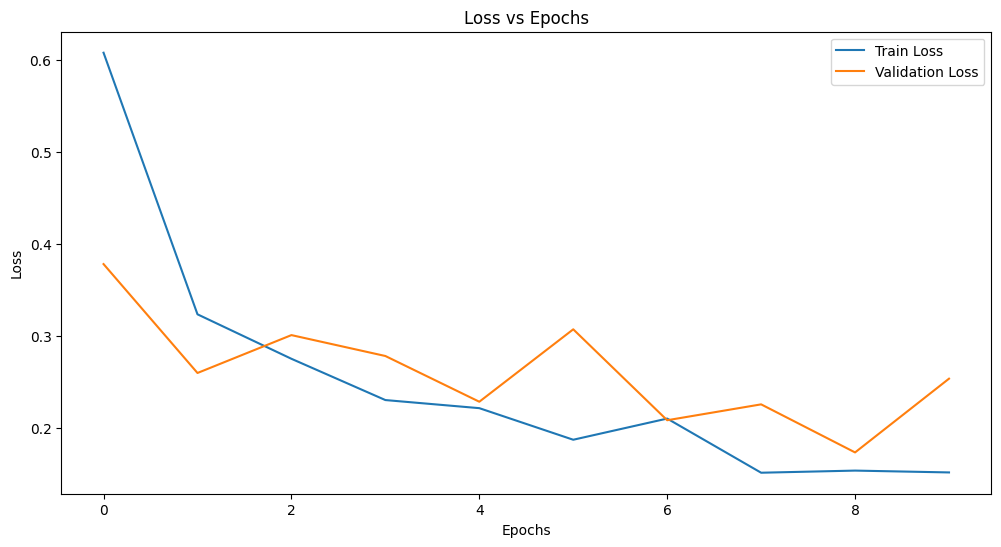

Generating Confusion Matrix...
41/41 ━━━━━━━━━━━━━━━━━━━━ 39s 547ms/step


<Figure size 1000x800 with 0 Axes>

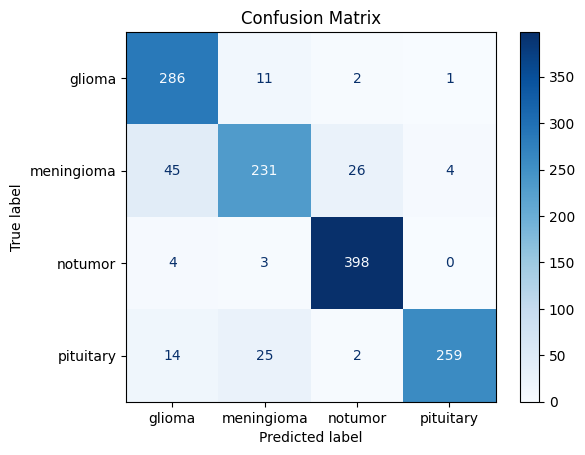

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Paths to Dataset
TRAIN_DIR = "/content/dataset/Training"  # Replace with the path to the Training folder
TEST_DIR = "/content/dataset/Testing"    # Replace with the path to the Testing folder

# Image settings
IMG_SIZE = (224, 224)  # Resize all images to this size
BATCH_SIZE = 32

# Step 1: Load Dataset
print("Loading Dataset...")

train_dataset = image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',  # One-hot encoding labels
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Save class names before preprocessing the dataset
class_names = test_dataset.class_names  # Save class names for later use

# Split train dataset into train (80%) and validation (20%)
val_dataset = train_dataset.take(int(0.2 * len(train_dataset)))  # Take 20% for validation
train_dataset = train_dataset.skip(int(0.2 * len(train_dataset)))  # Remaining for training

print(f"Training dataset size: {len(train_dataset)} batches")
print(f"Validation dataset size: {len(val_dataset)} batches")
print(f"Testing dataset size: {len(test_dataset)} batches")

# Step 2: Normalize and Cache Datasets
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)  # Normalize images to [0, 1]

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Step 3: Prepare Multi-Input Datasets
def prepare_multi_input_dataset(dataset):
    """
    Converts the dataset for use in the multi-input model.
    Each image is duplicated for separate branches (e.g., EfficientNet, DenseNet, AlexNet).
    """
    return dataset.map(lambda x, y: ((x, x, x), y))  # Three inputs, one for each branch

train_dataset_multi = prepare_multi_input_dataset(train_dataset)
val_dataset_multi = prepare_multi_input_dataset(val_dataset)
test_dataset_multi = prepare_multi_input_dataset(test_dataset)

# Step 4: Define the Multi-Branch Model
def build_combined_model(input_shape=(224, 224, 3), num_classes=4):
    """
    Build the multi-branch model combining EfficientNet, DenseNet, and AlexNet-like architecture.
    """
    # EfficientNetB0 Branch
    efficient_net = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    efficient_net.trainable = False  # Freeze EfficientNet layers
    x1 = GlobalAveragePooling2D()(efficient_net.output)

    # DenseNet121 Branch
    densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
    densenet.trainable = False  # Freeze DenseNet layers
    x2 = GlobalAveragePooling2D()(densenet.output)

    # AlexNet-like Branch
    alexnet_input = Input(shape=input_shape)
    x3 = Conv2D(96, (11, 11), strides=4, activation="relu")(alexnet_input)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Conv2D(256, (5, 5), padding="same", activation="relu")(x3)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Conv2D(384, (3, 3), padding="same", activation="relu")(x3)
    x3 = Conv2D(384, (3, 3), padding="same", activation="relu")(x3)
    x3 = Conv2D(256, (3, 3), padding="same", activation="relu")(x3)
    x3 = MaxPooling2D((3, 3), strides=2)(x3)
    x3 = Flatten()(x3)

    # Combine the outputs of the three branches
    combined = concatenate([x1, x2, x3])
    fc = Dense(512, activation="relu")(combined)
    fc = Dense(128, activation="relu")(fc)
    output = Dense(num_classes, activation="softmax")(fc)  # Output layer with 4 classes

    # Create final model
    model = Model(inputs=[efficient_net.input, densenet.input, alexnet_input], outputs=output)
    return model

# Step 5: Build the Model
print("Building Model...")
model = build_combined_model()
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# Step 6: Train the Model
print("Training Model...")
history = model.fit(
    train_dataset_multi,
    validation_data=val_dataset_multi,
    epochs=10,
    batch_size=BATCH_SIZE
)

# Step 7: Evaluate the Model
print("Evaluating Model...")
test_loss, test_acc = model.evaluate(test_dataset_multi)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Step 8: Visualize Training/Validation Metrics
plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# Step 9: Generate a Confusion Matrix
print("Generating Confusion Matrix...")

# Get true labels and predictions for the test dataset
y_true = np.concatenate([y.numpy() for _, y in test_dataset])
y_pred_probs = model.predict(test_dataset_multi)  # Model predictions (as probabilities)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert predicted probabilities to class indices
y_true = np.argmax(y_true, axis=1)  # Convert one-hot true labels to class indices

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, colorbar=True)  # Use a blue color map
plt.title("Confusion Matrix")
plt.show()